# Myers-Briggs Personality Prediction

#### by Weston Shuken

---

## Overview

The purpose of this project is to use machine learning algorithms to precict the personality type of a person given their written text in English. The personality type predictions are based on the Myers-Briggs Type Indicator (MBTI) test as the target variable. The features or predictor variables are comments and posts from userson [PersonalityCafe](https://www.personalitycafe.com/). These posts and comments come from users who have explicitley labeled their MBTI personality on their profile. 

The Myers-Briggs test is a very popular test that ask users approximately 90 questions about their behavior and assigns the user a type of personality based on this assessment. This test takes around 20-30 for someone to complete. 

There are 16 different personality types using a combination of 8 overall traits. See below:

    Introversion (I) vs Extroversion (E)
    Intuition (N) vs Sensing (S)
    Thinking (T) vs Feeling (F)
    Judging (J) vs Perceiving (P)
    

## Exploratory Data Analysis

In [1]:
# Imports for EDA, Cleaning, Plotting & Modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag


from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from mbti import run_models, preprocess

# Random Seed for everything
SEED = 53188535

In [2]:
# Loading the Data
cafe_df = pd.read_csv('data/mbti_1.csv')

In [3]:
cafe_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [4]:
cafe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [5]:
cafe_df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

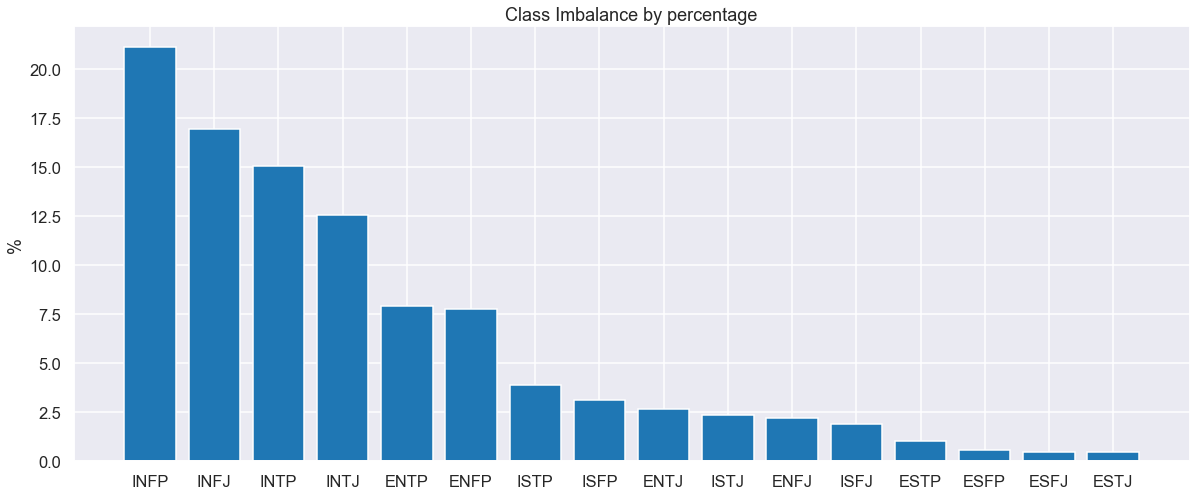

In [6]:
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(20,8))
plt.bar(cafe_df['type'].value_counts(normalize=True).index, cafe_df['type'].value_counts(normalize=True).values*100)
plt.title('Class Imbalance by percentage')
plt.ylabel('%');

In [7]:
# looking at a random posts
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_df['posts'].iloc[rint][:1000])

## BE CAREFUL... Reddit posts can sometimes be quite rude...

>>>>>>>>>>INFP<<<<<<<<<<
-------------------------
'I only know one other, my son. Is our type really that rare? I can at times notice the types in people I work with, come across in a social setting, etc. but I have never come across someone where I...|||I have used dating sites in the past as I feel highly uncomfortable going out and about trying to get to know others. Meeting people online is the new norm however sadly people are more bold behind...|||How does this highly introverted person become more outgoing? How come no one is asking for advice?|||The power of intention plays a strong role in how we approach relationships whether they are romantic or platonic. Falling for someone can happen unexpectedly and very easily when we begin to...|||Los Angeles, Calif|||The flat is yours not his, respect should be going both ways which he isnt giving. Always talk in person, text seems to lead to miscommunication. Its funny how infps can be so laid back but when...|||Infp's value complete

#### Takeaways from seeing the dataset:

- The classes are quite imbalanced, which can bias the model to choosing one class over the other just given class weight.
- There is a lot of cleaning to do with the text (lowercase, remove urls, remove symbols/punctuation, lemmitization, etc.)
- There are definitely incorrect spellings of words and acroynms like `lol` & `btw`
- The posts might include the personality type in them, which could be considered `data leakage`.

### Cleaning & Tokenizing

In [8]:
cafe_clean = cafe_df.copy()

In [9]:
# Lowercase y variables
cafe_clean['type'] = cafe_clean.type.str.lower()

# Creating list of the targets
mbti_lst = list(set(cafe_clean['type'].values))

# Lowercase X varaible onto a new column
cafe_clean['clean_posts'] = cafe_clean['posts'].str.lower()

In [10]:
# Bringing in the prepreoccess class from mbti.py
# This class provides functions to clean and tokenize our text data
prepro = preprocess()

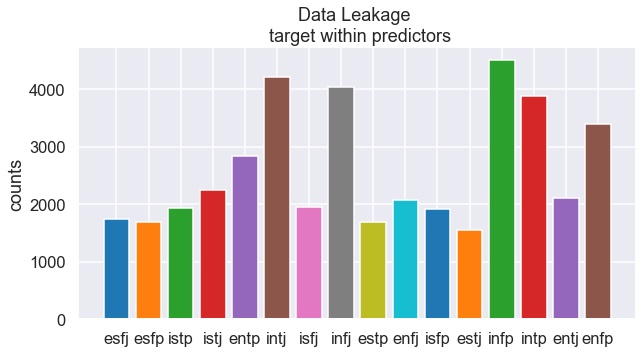

In [11]:
plt.figure(figsize=(10,5))
for mbti in mbti_lst:
    plt.bar(str(mbti), len(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index))
    plt.title('Data Leakage \n target within predictors')
    plt.ylabel('counts')
    # print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

In [12]:
# Remove the target names in the actual posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.replace_mbti(x))

In [13]:
cafe_clean

,type,posts,clean_posts
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'http://www.youtube.com/watch?v=qsxhcwe3krw|||...
1,entp,'I'm finding the lack of me in these posts ver...,'i'm finding the lack of me in these posts ver...
2,intp,'Good one _____ https://www.youtube.com/wat...,'good one _____ https://www.youtube.com/wat...
3,intj,"'Dear INTP, I enjoyed our conversation the o...","'dear , i enjoyed our conversation the other..."
4,entj,'You're fired.|||That's another silly misconce...,'you're fired.|||that's another silly misconce...
...,...,...,...
8670,isfp,'https://www.youtube.com/watch?v=t8edHB_h908||...,'https://www.youtube.com/watch?v=t8edhb_h908||...
8671,enfp,'So...if this thread already exists someplace ...,'so...if this thread already exists someplace ...
8672,intp,'So many questions when i do these things. I ...,'so many questions when i do these things. i ...
8673,infp,'I am very conflicted right now when it comes ...,'i am very conflicted right now when it comes ...


In [14]:
for mbti in mbti_lst:
    print(cafe_clean[cafe_clean['clean_posts'].str.contains(mbti)].index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


In [15]:
# The posts contain multiple posts seperated by 3 pipes '|||' w/ no spaces between. 
# This function will remove pipes and replace with a space.
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.pipe_remove(x))

# This funciton will remove URLs in the posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.url_remove(x))

# This function will remove punctuation (dependent on what is passed in). This has `/``, `_`, `:` 
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.punc_remove(x))

# Removes all characters that are not American Standard Code for Information Interchange
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.remove_symbols(x))

# Fixes all spelling errors
# cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(lambda x: prepro.spelling(x))

In [16]:
# This will create a column of cleaned words that have been tokenized.
pattern = r"(?u)\b\w\w+\b" # words with more than 2 letters
tokenizer = RegexpTokenizer(pattern) # instantiate tokenizer
cafe_clean['post_tokens'] = cafe_clean['clean_posts'].apply(tokenizer.tokenize) # Tokenize to new column

In [17]:
# Removing any remaining numeric digits
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.remove_dig_token(x))

# Removing stopwords
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.remove_stopwords(x))

# Lemmatizing the words with POS tagging
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.lemmend_pos(x)) # Takes a while

In [18]:
# Joining the tokens together into one long string
cafe_clean['joined_tokens'] = cafe_clean['post_tokens'].apply(lambda x: prepro.join_tokens(x)) # Creating new column

In [19]:
# showing what characters are in the cleaned text vs. the pre-cleaned text
clean_corpus = ' '.join(cafe_clean['joined_tokens'])
print(f'CLEANED: {"".join(sorted(set(clean_corpus.lower())))}')
print('-'*25)
print('-'*25)


corpus = ' '.join(cafe_df['posts'])
print(f'PRE-CLEANED: {"".join(sorted(set(corpus.lower())))}')

CLEANED:  abcdefghijklmnopqrstuvwxyz
-------------------------
-------------------------
PRE-CLEANED:  !#$%&'()*+,-./0123456789:;<=>?@[]^_`abcdefghijklmnopqrstuvwxyz{|}~¡¢£¤§¨©«¬®¯°²³´µ¶·¸¹º»¼½¾¿×ßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿāăćčđēĕėęěīĭıłńōŏőœřśšūżưǝɐɔəɛɟɥɪɯɹʇʊʌʍʎʒʖʘ˂˃ˆˈˌː˘˙˚˝˶̴̶̸̡̢̧̨̛̖̗̘̙̜̝̞̟̠̣̤̥̦̩̪̫̬̯̰̳̹̺̻̼͇͈͉͍͎̀́̂̃̄̆̇̈̉̌̎̐̑̒̓̔̽̾́̓͊̕̚ͅ͏͓͔͕͖͙͚͑͒͛ͣͤͥͦͧͨͩͫͭͮ͘͜͟͢͝͞͡άέήίαβγδεηθικλμνξοπρςστυφψωόύώабвгдежзийклмнопрстуфхцчшщъыьэюяћќ҉אבגדהוזחיךלםמןנסעפץרשת،؟أابةتثجحدرزسشظعغفقكلمنهوي٩کگی۶ःतमरिू्ஐ௰ಠಡಥರೃฅง็๑ຈ༼༽ლღᆺ፦ᴗởἓἔἶὅὐὲ–—―‘’‚“”„†•…′‽‿⁎₪€™↑→↔⇑⇩∀∇∈∑−∙√∞≈≠≡≥≦≧⊃⊙⋆⌒⌣─━┌┐┬┻╥╬╭╮╯■□▬△▽◇◉●◔◕◞◠◡☂★☆☺☼♉♡♢♤♥♧♪♫♬✌✍✓✔✝✧✨✿❤⸮、。》あいうえおかがきぎくこごさざしじすせぜそただちっつづてでとなにねのはへぼまめもゃやょよらりるれろわをん゜アイクサジタッツトニノミメモュラレヮワン・ーヽヾㅿ一上不中之习了事二人仙会但你便像光全兴冬刀利到勇吉同吗吞呢喜四因国地夜夢大天太头好如学安実容小就弁待很我才把抜拿掌文斎斬新方日明易是智暗曉月望本柳欢気汉漫為然爱狼王白的益眼砂祥私笑組美聖花英菀西見語语说迎返違選都野関陰陽雪願馬髒高龍녕디랑뮤보비사석세씨아안오요유재저직하️︵﹏！％＇（）＊，－０１：；？＠｀ａｂｃｄｅｆｇｈｉｋｌｍｎｏｐｒｓｔｕｖｗｘｙ～｡･ｧｩｫｬｼﾉﾞﾟ￣�🌹🍄🏼🐍👈👋👌👍👏💎💓💖💛🔥🕚😀😁😂😃😄😅😆😇😉😊😋😌😍😎😏😐😓😕😘😜😝😞😡😢😣😧😫😬😮😱😳😴😺🙋🤓🤔🤗🦄


In [20]:
cafe_clean.head(5)

,type,posts,clean_posts,post_tokens,joined_tokens
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top te...,"[moment, sportscenter, top, ten, play, pranks,...",moment sportscenter top ten play pranks life c...
1,entp,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...,"[im, find, lack, post, alarm, sex, boring, pos...",im find lack post alarm sex boring position of...
2,intp,'Good one _____ https://www.youtube.com/wat...,"good one of course, to which i say i kn...","[good, one, course, say, know, thats, bless, c...",good one course say know thats bless curse abs...
3,intj,"'Dear INTP, I enjoyed our conversation the o...","dear , i enjoyed our conversation the other ...","[dear, enjoyed, conversation, day, esoteric, g...",dear enjoyed conversation day esoteric gabbing...
4,entj,'You're fired.|||That's another silly misconce...,youre fired. thats another silly misconcepti...,"[youre, fire, thats, another, silly, misconcep...",youre fire thats another silly misconception a...


---

The pre-cleaned tokens tally up to 10637645 total words
The cleaned tokens tally up to 5378285 total words
--------------------
Each feature in pre-cleaned has on average 1226 words
Each feature in cleaned has on average 620 words
--------------------
Each feature in pre-cleaned  has a median of 1278 words
Each feature has a median of 645 words
--------------------
The minimum post in pre-cleaned  is 4 words
The minimum post in cleaned is 0 words
--------------------
The minimum post in pre-cleaned  is 1881 words
The minimum post in cleaned is 916 words
--------------------


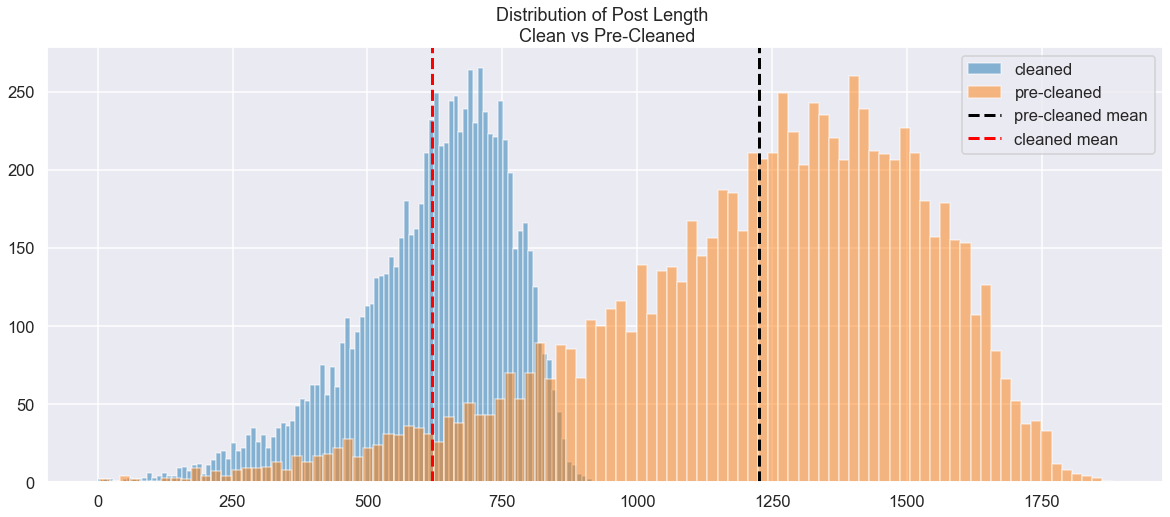

In [21]:
total_words = cafe_clean['posts'].apply(lambda x: len(x.split())).sum()
print(f'The pre-cleaned tokens tally up to {total_words} total words')

clean_words = cafe_clean['post_tokens'].apply(lambda x: len(x)).sum()
print(f'The cleaned tokens tally up to {clean_words} total words')

print('-'*20)

ave_post = cafe_clean['posts'].apply(lambda x: len(x.split())).mean()
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

ave_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).mean()
print(f'Each feature in cleaned has on average {round(ave_cleaned)} words')

print('-'*20)

med_post = cafe_clean['posts'].apply(lambda x: len(x.split())).median()
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

med_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).median()
print(f'Each feature has a median of {round(med_cleaned)} words')

print('-'*20)

min_post = cafe_clean['posts'].apply(lambda x: len(x.split())).min()
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

min_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).min()
print(f'The minimum post in cleaned is {round(min_cleaned)} words')

print('-'*20)

max_post = cafe_clean['posts'].apply(lambda x: len(x.split())).max()
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')

max_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).max()
print(f'The minimum post in cleaned is {round(max_cleaned)} words')

print('-'*20)

plt.figure(figsize=(20,8))
plt.hist(cafe_clean['post_tokens'].apply(lambda x: len(x)), label='cleaned', alpha=.5, bins=100)
plt.hist(cafe_clean['posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.axvline(ave_cleaned, color='r', linestyle='dashed', linewidth=3, label='cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [22]:
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_clean['posts'].iloc[rint][:1000])
print('-'*25)
print(cafe_clean['joined_tokens'].iloc[rint][:1000])

>>>>>>>>>>ENTP<<<<<<<<<<
-------------------------
'http://www.youtube.com/watch?v=xQ04WbgI9rg&ob=av2e   http://www.youtube.com/watch?v=gGdGFtwCNBE&ob=av3e   http://www.youtube.com/watch?v=gH2efAcmBQM&ob=av3e  ...|||What we did is inform each other what our love languages were, and both of our primaries are physical touch. So hugs, cuddling, hand holding, all that cute-sy crap that couples do... we're big on...|||I am currently dating an INTJ.   Objectively, she is the most compatible woman for me from all of my relationships heretofore. This was an observation by both of us (eventually) and all of our...|||Quite, actually. It keeps us alive :)|||This is that one, I'm just posting it here for the people that don't visit the overall forum. A friend pointed me to it originally.|||The following link is a map where you can post your location and MBTI type, let's show all those other types that the ENTP's are more awesome than they already thought because we're everywhere!! :D ...|||After h

#### Takeaways:
- A lot of words were reduced or eliminated that did not provide any use.
- The dataset still has posts with very little words. Might need to drop these.
- The lemmitization did not work well on some verbs and the `MBTI` replacement often is followed by an `s`.


In [23]:
# Adding Binary Targets
cafe_clean['i/e'] = cafe_clean['type'].map(lambda x: x[0])
cafe_clean['n/s'] = cafe_clean['type'].map(lambda x: x[1])
cafe_clean['t/f'] = cafe_clean['type'].map(lambda x: x[2])
cafe_clean['p/j'] = cafe_clean['type'].map(lambda x: x[3])

In [24]:
print(cafe_clean['i/e'].value_counts())
print(cafe_clean['n/s'].value_counts())
print(cafe_clean['t/f'].value_counts())
print(cafe_clean['p/j'].value_counts())

i    6676
e    1999
Name: i/e, dtype: int64
n    7478
s    1197
Name: n/s, dtype: int64
f    4694
t    3981
Name: t/f, dtype: int64
p    5241
j    3434
Name: p/j, dtype: int64


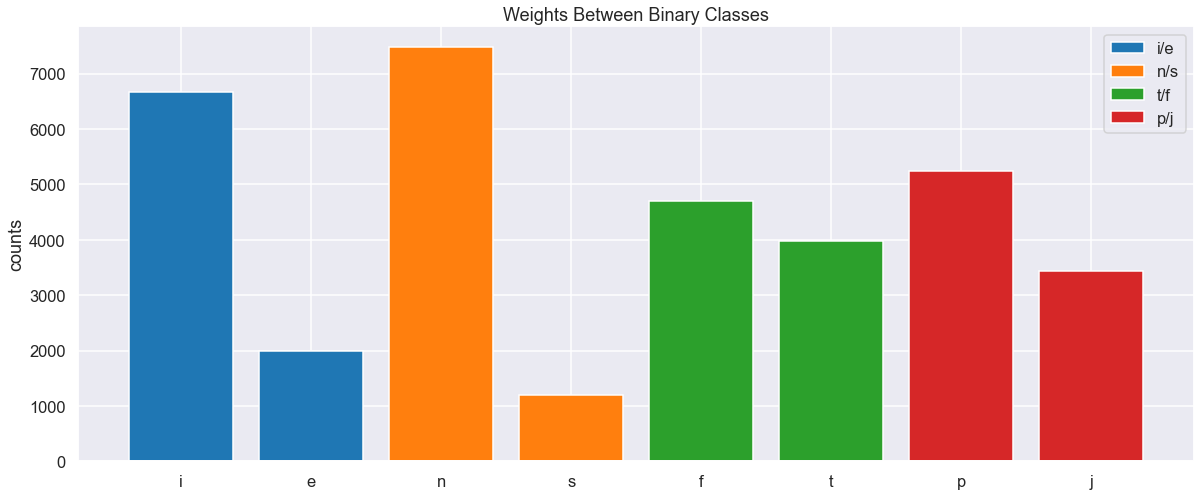

In [25]:
plt.figure(figsize=(20,8))
plt.title('Weights Between Binary Classes')
plt.ylabel('counts')
for column in cafe_clean.columns[-4:]:
    plt.bar(cafe_clean[column].value_counts().index, cafe_clean[column].value_counts().values, label=column)

plt.legend()
plt.show();

### Sentiment Analysis w/ VADER

In [26]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [27]:
sid.polarity_scores(cafe_clean.loc[2,'joined_tokens'])

{'neg': 0.109, 'neu': 0.599, 'pos': 0.292, 'compound': 0.9985}

In [28]:
cafe_clean['sentiment'] = cafe_clean['joined_tokens'].apply(lambda x: sid.polarity_scores(x))

In [29]:
cafe_clean['sentiment_total'] = cafe_clean['sentiment'].apply(lambda x: x['compound'])

In [30]:
cafe_clean['sentiment_score'] = cafe_clean['sentiment_total'].apply(lambda x: '+' if x >= 0 else '-')

Average Sentiemnt Score for esfj: 0.9973785714285716
Average Sentiemnt Score for esfp: 0.8515062499999999
Average Sentiemnt Score for istp: 0.8486275964391692
Average Sentiemnt Score for istj: 0.9169868292682928
Average Sentiemnt Score for entp: 0.9007751824817517
Average Sentiemnt Score for intj: 0.8949363886342806
Average Sentiemnt Score for isfj: 0.9542283132530119
Average Sentiemnt Score for infj: 0.9543682993197279
Average Sentiemnt Score for estp: 0.9377943820224719
Average Sentiemnt Score for enfj: 0.9721736842105261
Average Sentiemnt Score for isfp: 0.9587029520295203
Average Sentiemnt Score for estj: 0.8641205128205127
Average Sentiemnt Score for infp: 0.9341299672489084
Average Sentiemnt Score for intp: 0.861783819018405
Average Sentiemnt Score for entj: 0.9246627705627706
Average Sentiemnt Score for enfp: 0.9820238518518518


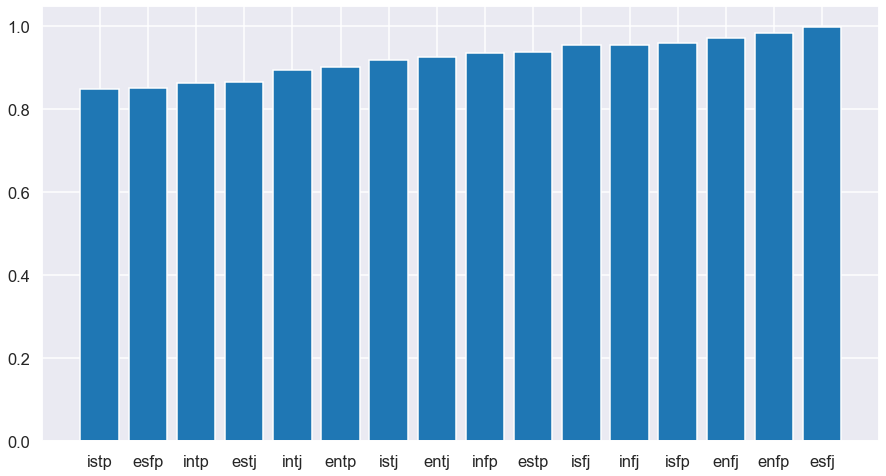

In [31]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.sentiment_total.mean()}')
    scores_dict.update({mbti: data.sentiment_total.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height);


Average Sentiemnt Score for t: 0.8846782215523737
Average Sentiemnt Score for f: 0.950745462292288


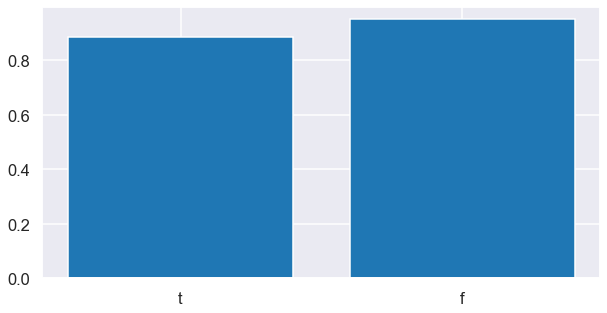

In [32]:
scores_dict = {}
for mbti in ['t', 'f']:
    data = cafe_clean[cafe_clean['t/f'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.sentiment_total.mean()}')
    scores_dict.update({mbti: data.sentiment_total.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(10,5))
plt.bar(x, height);

In [33]:
cafe_clean['polarity'] = cafe_clean['joined_tokens'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [34]:
cafe_clean['subjectivity'] = cafe_clean['joined_tokens'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

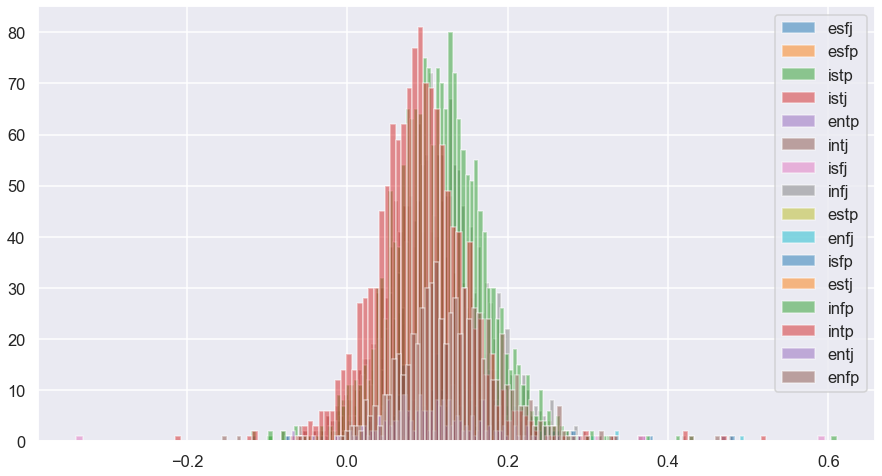

In [35]:
plt.figure(figsize=(15,8))
for mbti in mbti_lst:
    plt.hist(cafe_clean['polarity'][cafe_clean['type'] == mbti], bins=100, alpha=.5, label=mbti)
    plt.legend();

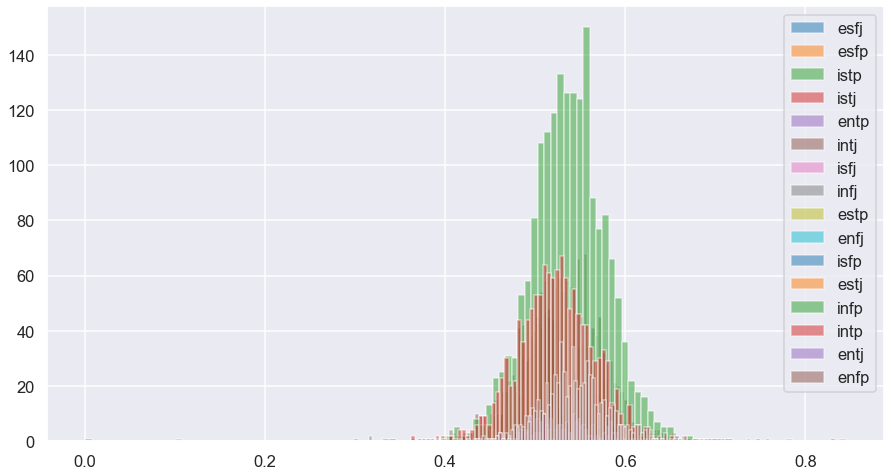

In [36]:
plt.figure(figsize=(15,8))
for mbti in mbti_lst:
    plt.hist(cafe_clean['subjectivity'][cafe_clean['type'] == mbti], bins=100, alpha=.5, label=mbti)
    plt.legend();

Average Sentiemnt Score for esfj: 0.13974941063609087
Average Sentiemnt Score for esfp: 0.1123108862472287
Average Sentiemnt Score for istp: 0.09560499803791665
Average Sentiemnt Score for istj: 0.10781608359902514
Average Sentiemnt Score for entp: 0.10507150630764782
Average Sentiemnt Score for intj: 0.0977010633335242
Average Sentiemnt Score for isfj: 0.12451931247148186
Average Sentiemnt Score for infj: 0.11906580031327872
Average Sentiemnt Score for estp: 0.11705505364052353
Average Sentiemnt Score for enfj: 0.14527312442101964
Average Sentiemnt Score for isfp: 0.1295808975889368
Average Sentiemnt Score for estj: 0.11027807551621582
Average Sentiemnt Score for infp: 0.11546259330606959
Average Sentiemnt Score for intp: 0.09081179194750634
Average Sentiemnt Score for entj: 0.10731474725204874
Average Sentiemnt Score for enfp: 0.13219131688975677


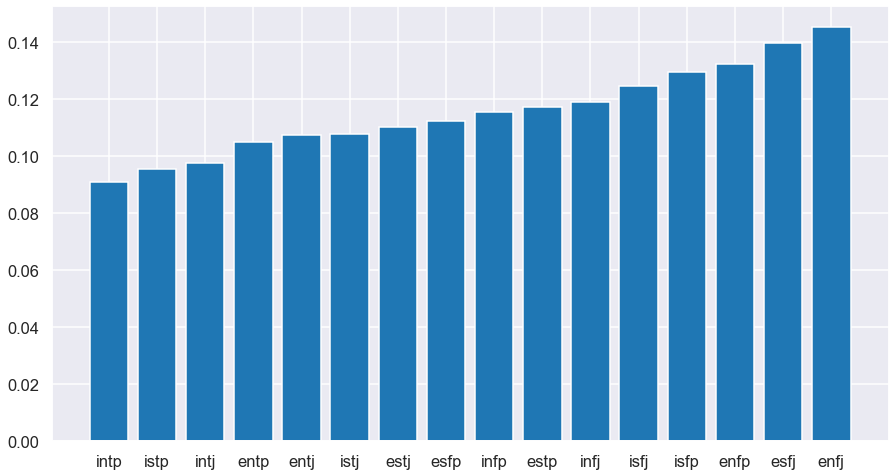

In [37]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.polarity.mean()}')
    scores_dict.update({mbti: data.polarity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height);

Average Sentiemnt Score for esfj: 0.5402837713439674
Average Sentiemnt Score for esfp: 0.5379531017871956
Average Sentiemnt Score for istp: 0.5245042099556155
Average Sentiemnt Score for istj: 0.5186690787798689
Average Sentiemnt Score for entp: 0.5329137352800885
Average Sentiemnt Score for intj: 0.5222922100722998
Average Sentiemnt Score for isfj: 0.5411851563667872
Average Sentiemnt Score for infj: 0.5335959484561393
Average Sentiemnt Score for estp: 0.5342812867435218
Average Sentiemnt Score for enfj: 0.5465322525899637
Average Sentiemnt Score for isfp: 0.5380906836576977
Average Sentiemnt Score for estj: 0.5239120672220323
Average Sentiemnt Score for infp: 0.5366130406834448
Average Sentiemnt Score for intp: 0.523919729906809
Average Sentiemnt Score for entj: 0.5297599613258778
Average Sentiemnt Score for enfp: 0.5439599694245157


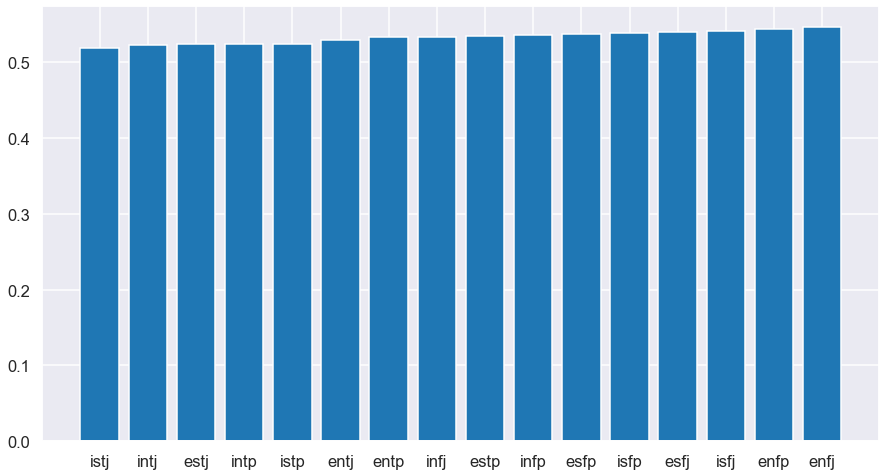

In [38]:
scores_dict = {}
for mbti in mbti_lst:
    data = cafe_clean[cafe_clean['type'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.subjectivity.mean()}')
    scores_dict.update({mbti: data.subjectivity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(15,8))
plt.bar(x, height);

Average Sentiemnt Score for t: 0.09816981949964891
Average Sentiemnt Score for f: 0.12152370192613325


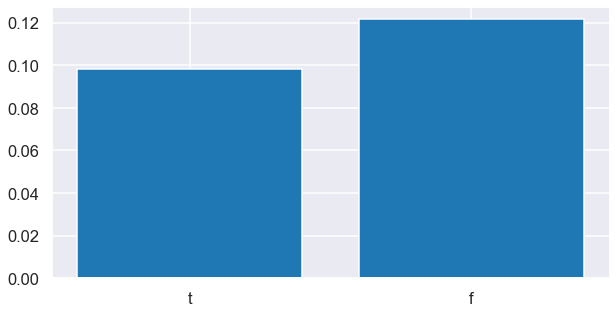

In [39]:
scores_dict = {}
for mbti in ['t', 'f']:
    data = cafe_clean[cafe_clean['t/f'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.polarity.mean()}')
    scores_dict.update({mbti: data.polarity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(10,5))
plt.bar(x, height);

Average Sentiemnt Score for t: 0.525370829883759
Average Sentiemnt Score for f: 0.5374197317057077


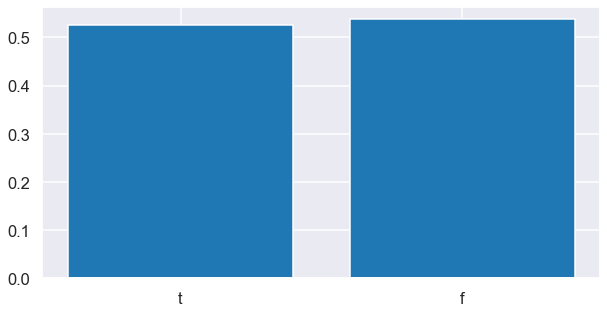

In [40]:
scores_dict = {}
for mbti in ['t', 'f']:
    data = cafe_clean[cafe_clean['t/f'] == mbti]
    print(f'Average Sentiemnt Score for {mbti}: {data.subjectivity.mean()}')
    scores_dict.update({mbti: data.subjectivity.mean()}) 

scores_dict = {k: v for k, v in sorted(scores_dict.items(), key=lambda item: item[1])}

x = list(scores_dict.keys())
height = list(scores_dict.values())

plt.figure(figsize=(10,5))
plt.bar(x, height);

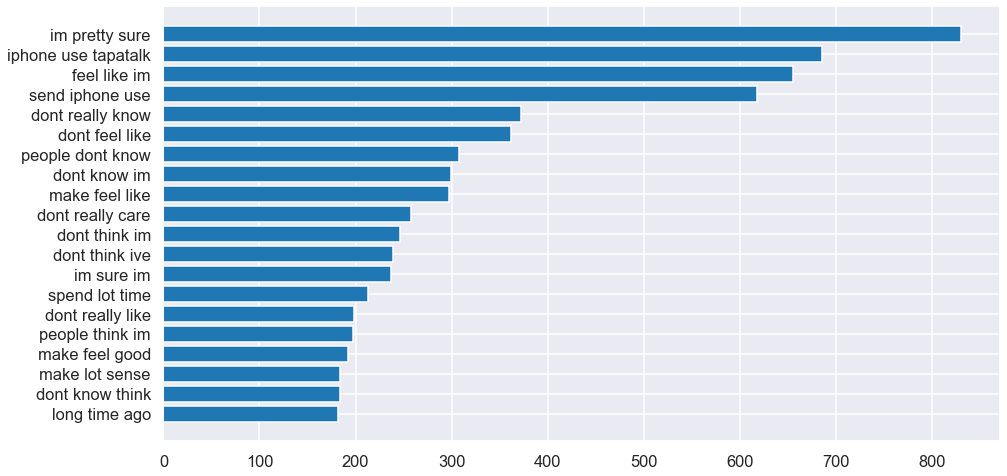

In [41]:
# Susan Li
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(cafe_clean['joined_tokens'], 20)
# for word, freq in common_words:
#     print(word, freq)
df_tgrams = pd.DataFrame(common_words, columns = ['Posts' , 'count'])
df_tgrams = df_tgrams.groupby('Posts').sum()['count'].sort_values(ascending=True)
plt.figure(figsize=(15,8))
plt.barh(df_tgrams.index, df_tgrams.values);


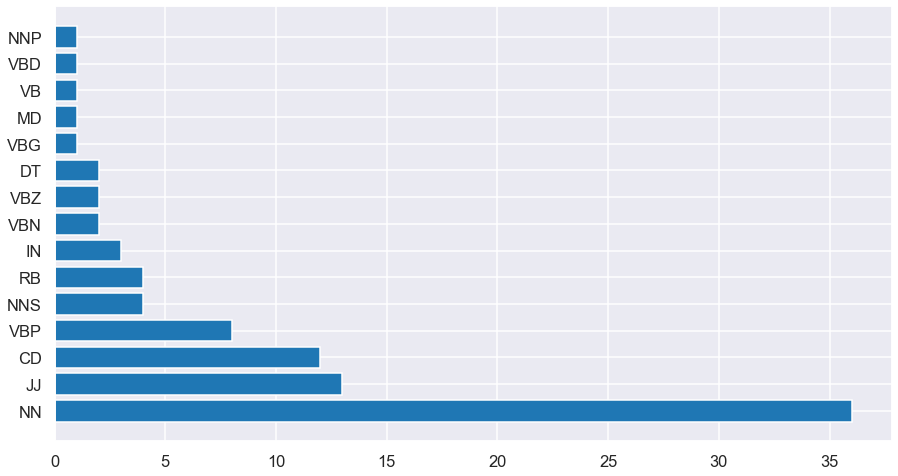

In [42]:
blob = TextBlob(str(cafe_clean['joined_tokens']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
plt.figure(figsize=(15,8))
plt.barh(pos_df.index, pos_df.values);

In [43]:
# cafe_clean.to_csv('./data/cafe_clean_new.csv')

## Modeling

There will be 4 sections of modeling:

1. Multiclass
2. Multiclass balanced classes using undersampling
3. Binary
4. Binary balanced classes using undersampling

In [44]:
# Baseline
baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED),

                #   'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga'),

                  'NaiveBayes': MultinomialNB()
               
                #   'DecisionTree': DecisionTreeClassifier(random_state=SEED),
               
                #   'RandomForest': RandomForestClassifier(random_state=SEED)
               }

In [45]:
for clf in baseline_models:
    print(baseline_models[clf])

SGDClassifier(class_weight='balanced', random_state=53188535)
MultinomialNB()


In [46]:
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [47]:
rm = run_models()

In [48]:
rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=False, SEED=234)

--------------------
Vectorizing....  @ Wed Mar  2 18:11:06 2022
Working on SGDClassifier for type @ Wed Mar  2 18:11:16 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for type @ Wed Mar  2 18:11:39 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.3448,0.3476
1,NaiveBayes_type,type,0.2193,0.2144


In [49]:
rm.run(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=True, SEED=234)

--------------------
Vectorizing....  @ Wed Mar  2 18:11:43 2022
Working on SGDClassifier for type @ Wed Mar  2 18:11:54 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for type @ Wed Mar  2 18:12:13 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.4202,0.4108
1,NaiveBayes_type,type,0.2115,0.2098


(0.0, 1.0)

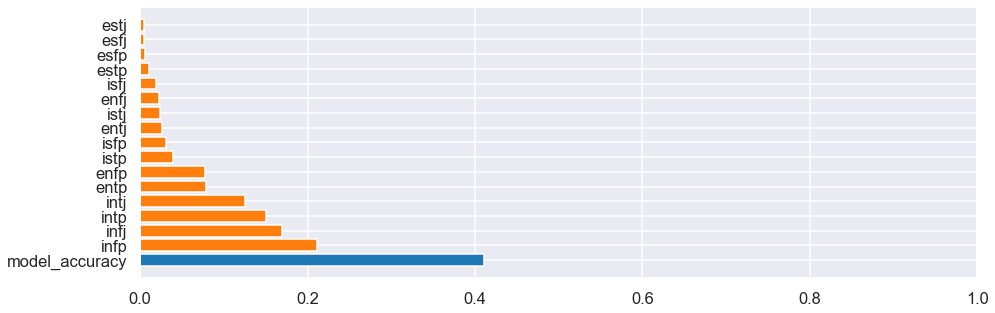

In [50]:
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .4108)
plt.barh(cafe_clean['type'].value_counts(normalize=True).index, cafe_clean['type'].value_counts(normalize=True).values)
plt.xlim(0, 1)

#### Multiclass Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [51]:
rm.run_usampled(cafe_clean, 'joined_tokens', ['type'], baseline_models, models_table, tfidf=True, SEED=234)

(array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([ 142,  506,  173,  514,   32,   36,   29,   67, 1102, 1374,  818,
        978,  125,  203,  154,  253]))
(array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]))
Vectorizing....  @ Wed Mar  2 18:12:16 2022
Working on SGDClassifier @ Wed Mar  2 18:12:18 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Wed Mar  2 18:12:19 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.0884,0.1355
1,NaiveBayes_type,type,0.0969,0.035


(0.0, 1.0)

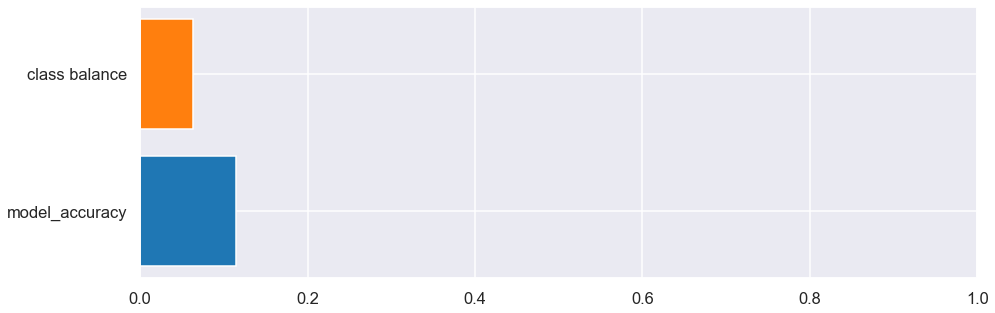

In [52]:
plt.figure(figsize=(15,5))
plt.barh('model_accuracy', .1143)
plt.barh('class balance', 1/16)
plt.xlim(0, 1)

### Multiclass Undersampled Models Results
The largest class is `infp` of 21%. The models are not performing at a useful level, however there is reason to believe that the models are finding some distinction in word usage between the different MBTI types.

---

In [53]:
print(cafe_clean['i/e'].value_counts(normalize=True))
print(cafe_clean['n/s'].value_counts(normalize=True))
print(cafe_clean['t/f'].value_counts(normalize=True))
print(cafe_clean['p/j'].value_counts(normalize=True))

i    0.769568
e    0.230432
Name: i/e, dtype: float64
n    0.862017
s    0.137983
Name: n/s, dtype: float64
f    0.541095
t    0.458905
Name: t/f, dtype: float64
p    0.60415
j    0.39585
Name: p/j, dtype: float64


In [54]:
bin_targets = cafe_clean.columns[-9:-5]
bin_targets

Index(['i/e', 'n/s', 't/f', 'p/j'], dtype='object')

In [55]:
rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

--------------------
Vectorizing....  @ Wed Mar  2 18:12:19 2022
Working on SGDClassifier for i/e @ Wed Mar  2 18:12:29 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for i/e @ Wed Mar  2 18:12:32 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Wed Mar  2 18:12:32 2022
Working on SGDClassifier for n/s @ Wed Mar  2 18:12:42 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for n/s @ Wed Mar  2 18:12:43 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Wed Mar  2 18:12:44 2022
Working on SGDClassifier for t/f @ Wed Mar  2 18:12:53 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for t/f @ Wed Mar  2 18:12:56 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Wed Mar  2 18:12:56 2022
Working on SGDClassifier for p/j @ Wed Mar  2 18:13:06 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for p/j @ Wed Mar  2 18:13:08 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7808,0.7833
1,NaiveBayes_i/e,i/e,0.7704,0.7672
2,SGDClassifier_n/s,n/s,0.8647,0.8575
3,NaiveBayes_n/s,n/s,0.8644,0.8548
4,SGDClassifier_t/f,t/f,0.802,0.7921
5,NaiveBayes_t/f,t/f,0.5458,0.5288
6,SGDClassifier_p/j,p/j,0.6805,0.681
7,NaiveBayes_p/j,p/j,0.6101,0.5864


In [56]:
rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

--------------------
Vectorizing....  @ Wed Mar  2 18:13:09 2022
Working on SGDClassifier for i/e @ Wed Mar  2 18:13:18 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for i/e @ Wed Mar  2 18:13:20 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Wed Mar  2 18:13:21 2022
Working on SGDClassifier for n/s @ Wed Mar  2 18:13:30 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for n/s @ Wed Mar  2 18:13:32 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Wed Mar  2 18:13:33 2022
Working on SGDClassifier for t/f @ Wed Mar  2 18:13:42 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for t/f @ Wed Mar  2 18:13:44 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


--------------------
Vectorizing....  @ Wed Mar  2 18:13:45 2022
Working on SGDClassifier for p/j @ Wed Mar  2 18:13:54 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes for p/j @ Wed Mar  2 18:13:56 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7676,0.7391
1,NaiveBayes_i/e,i/e,0.7684,0.7672
2,SGDClassifier_n/s,n/s,0.8481,0.8506
3,NaiveBayes_n/s,n/s,0.8641,0.8548
4,SGDClassifier_t/f,t/f,0.7693,0.7718
5,NaiveBayes_t/f,t/f,0.688,0.6196
6,SGDClassifier_p/j,p/j,0.6466,0.6561
7,NaiveBayes_p/j,p/j,0.6211,0.5874


Accuracy increase from class balance in i/e is: 0.01
Accuracy increase from class balance in n/s is: -0.01
Accuracy increase from class balance in t/f is: 0.25
Accuracy increase from class balance in p/j is: 0.08


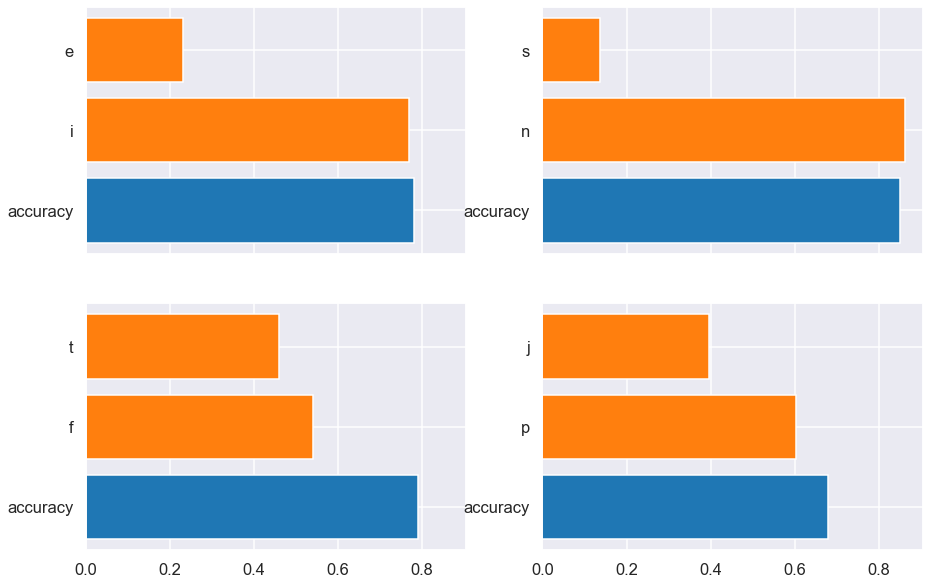

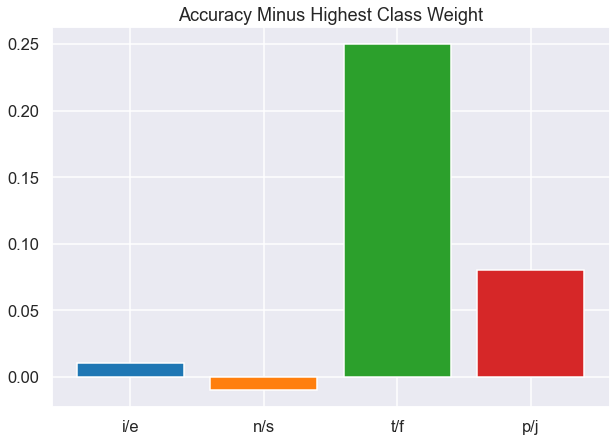

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .78)
axs[0, 0].barh(cafe_clean['i/e'].value_counts(normalize=True).index, cafe_clean['i/e'].value_counts(normalize=True).values)

axs[0,1].barh('accuracy', .85)
axs[0,1].barh(cafe_clean['n/s'].value_counts(normalize=True).index, cafe_clean['n/s'].value_counts(normalize=True).values)

axs[1,0].barh('accuracy', .79)
axs[1,0].barh(cafe_clean['t/f'].value_counts(normalize=True).index, cafe_clean['t/f'].value_counts(normalize=True).values)

axs[1,1].barh('accuracy', .68)
axs[1,1].barh(cafe_clean['p/j'].value_counts(normalize=True).index, cafe_clean['p/j'].value_counts(normalize=True).values)

acc = [.78, .85, .79, .68]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    increase = round(acc[i] - cafe_clean[target].value_counts(normalize=True)[0], 2)
    print(f'Accuracy increase from class balance in {target} is: {increase}')
    plt.bar(target, increase)
plt.show();


In [58]:
rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

(array(['e', 'i'], dtype=object), array([1499, 5007]))
(array(['e', 'i'], dtype=object), array([1499, 1499]))
Vectorizing....  @ Wed Mar  2 18:13:57 2022
Working on SGDClassifier @ Wed Mar  2 18:14:02 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Wed Mar  2 18:14:03 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


(array(['n', 's'], dtype=object), array([5608,  898]))
(array(['n', 's'], dtype=object), array([898, 898]))
Vectorizing....  @ Wed Mar  2 18:14:03 2022
Working on SGDClassifier @ Wed Mar  2 18:14:06 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \
/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Wed Mar  2 18:14:07 2022
(array(['f', 't'], dtype=object), array([3520, 2986]))
(array(['f', 't'], dtype=object), array([2986, 2986]))
Vectorizing....  @ Wed Mar  2 18:14:07 2022
Working on SGDClassifier @ Wed Mar  2 18:14:15 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Wed Mar  2 18:14:17 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


(array(['j', 'p'], dtype=object), array([2575, 3931]))
(array(['j', 'p'], dtype=object), array([2575, 2575]))
Vectorizing....  @ Wed Mar  2 18:14:18 2022
Working on SGDClassifier @ Wed Mar  2 18:14:26 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Wed Mar  2 18:14:28 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.6418,0.6524
1,NaiveBayes_i/e,i/e,0.6684,0.663
2,SGDClassifier_n/s,n/s,0.6576,0.6607
3,NaiveBayes_n/s,n/s,0.6782,0.7146
4,SGDClassifier_t/f,t/f,0.7689,0.7727
5,NaiveBayes_t/f,t/f,0.7322,0.7271
6,SGDClassifier_p/j,p/j,0.6276,0.633
7,NaiveBayes_p/j,p/j,0.6452,0.6473


In [59]:
rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

(array(['e', 'i'], dtype=object), array([1499, 5007]))
(array(['e', 'i'], dtype=object), array([1499, 1499]))
Vectorizing....  @ Wed Mar  2 18:14:28 2022
Working on SGDClassifier @ Wed Mar  2 18:14:34 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Wed Mar  2 18:14:35 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


(array(['n', 's'], dtype=object), array([5608,  898]))
(array(['n', 's'], dtype=object), array([898, 898]))
Vectorizing....  @ Wed Mar  2 18:14:35 2022
Working on SGDClassifier @ Wed Mar  2 18:14:39 2022
Working on NaiveBayes @ Wed Mar  2 18:14:39 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \
/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


(array(['f', 't'], dtype=object), array([3520, 2986]))
(array(['f', 't'], dtype=object), array([2986, 2986]))
Vectorizing....  @ Wed Mar  2 18:14:39 2022
Working on SGDClassifier @ Wed Mar  2 18:14:49 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Wed Mar  2 18:14:51 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


(array(['j', 'p'], dtype=object), array([2575, 3931]))
(array(['j', 'p'], dtype=object), array([2575, 2575]))
Vectorizing....  @ Wed Mar  2 18:14:52 2022
Working on SGDClassifier @ Wed Mar  2 18:15:00 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


Working on NaiveBayes @ Wed Mar  2 18:15:02 2022


/Users/westonshuken/Documents/Myers/personality-prediction/mbti.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Model': model_name + "_" + target, 'Target': target, 'CVScore': round(cv_score_mean, 4), \


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.6801,0.6736
1,NaiveBayes_i/e,i/e,0.6671,0.6127
2,SGDClassifier_n/s,n/s,0.6776,0.7616
3,NaiveBayes_n/s,n/s,0.6765,0.7916
4,SGDClassifier_t/f,t/f,0.7977,0.8018
5,NaiveBayes_t/f,t/f,0.6683,0.6805
6,SGDClassifier_p/j,p/j,0.6683,0.6717
7,NaiveBayes_p/j,p/j,0.6404,0.6381


Accuracy increase from class balance in i/e is: 0.18
Accuracy increase from class balance in n/s is: 0.23
Accuracy increase from class balance in t/f is: 0.3
Accuracy increase from class balance in p/j is: 0.16


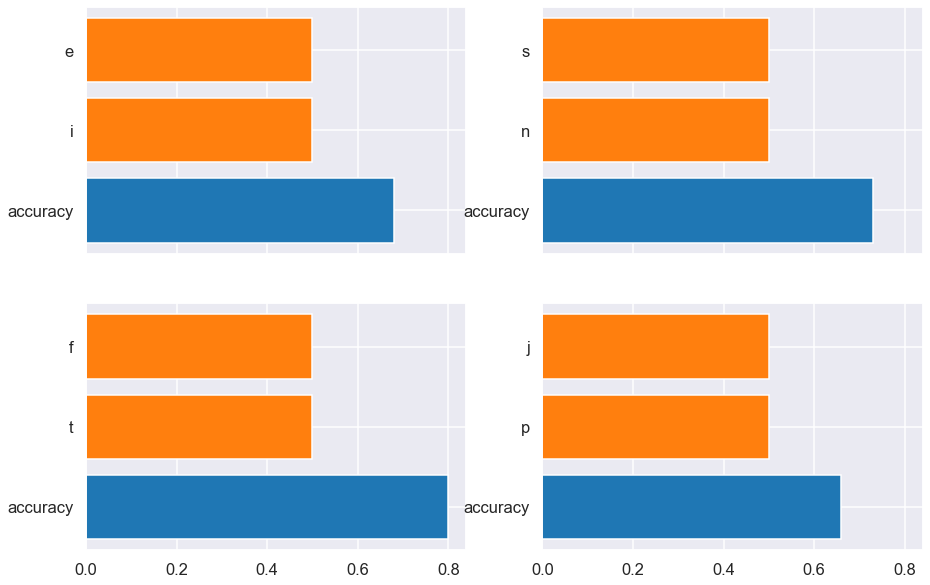

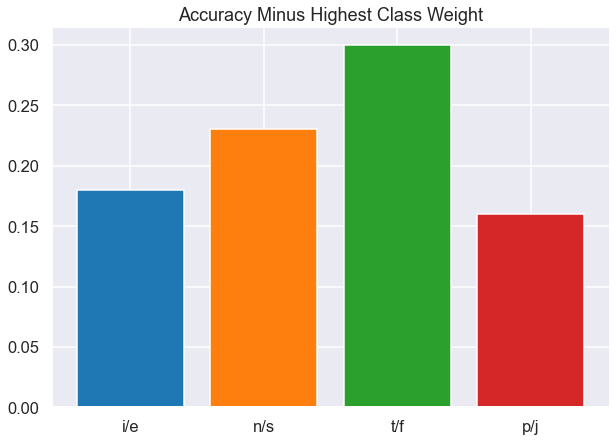

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True)
axs[0, 0].barh('accuracy', .68)
axs[0, 0].barh(['i', 'e'], [.5, .5])

axs[0,1].barh('accuracy', .73)
axs[0,1].barh(['n', 's'], [.5, .5])

axs[1,0].barh('accuracy', .8)
axs[1, 0].barh(['t', 'f'], [.5, .5])

axs[1,1].barh('accuracy', .66)
axs[1,1].barh(['p', 'j'], [.5, .5])

acc = [.68, .73, .8, .66]
plt.figure(figsize=(10,7))
plt.title('Accuracy Minus Highest Class Weight')
for i, target in enumerate(bin_targets):
    print(f'Accuracy increase from class balance in {target} is: {round(acc[i] - .5, 2)}')
    plt.bar(target, round(acc[i] - .5, 2))


---

## Model Tuning

In [61]:
cafe_clean = pd.read_csv('./data/cafe_clean.csv')

In [62]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(class_weight='balanced', random_state=SEED))
])

In [63]:
for target in bin_targets:
    X = cafe_clean['joined_tokens']
    y = cafe_clean[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)

    print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean[target].unique()))

    fig, ax = plt.subplots(figsize=(5,5))
    plt.rcParams.update({'font.size': 10})
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
    plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
    plt.grid(False);
    

ValueError: np.nan is an invalid document, expected byte or unicode string.

---

### i/e

In [ ]:
cafe_clean['i/e'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier( random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['i/e']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['i/e'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### n/s

In [ ]:
cafe_clean['n/s'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'s': .90, 'n': .10}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['n/s']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['n/s'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### t/f

In [ ]:
cafe_clean['t/f'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### p/j

In [ ]:
cafe_clean['p/j'].value_counts(normalize=True)

In [ ]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'p': .40, 'j': .60}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['p/j']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['p/j'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

## Final Model

In [ ]:
cafe_clean = pd.read_csv('./data/cafe_clean.csv')
cafe_clean.dropna(inplace=True)

In [ ]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

In [ ]:
f_test_sample = "I love being in engaging conversation something that doesnt bore me something \
meaningful and makes both of you feel good. But sometimes I get called intense is this just me? \
Like I could say well sometimes you bore me. Seems like Im the minority so its \
really nice when I meet someone my vibe as there arent many"

final_model.predict([f_test_sample])

In [ ]:
t_test_sample = "Nature provides exceptions to every rule. But this rule is applied to itself paradoxically. \
(So there must be some rules without any exception :)"

final_model.predict([t_test_sample])

## Further Inspect Thinking vs Feeling

In [ ]:
t_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 't'].explode())
f_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 'f'].explode())

In [ ]:
top_ten = list(zip(*t_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 THINKING Class Word Occurences');

In [ ]:
top_ten = list(zip(*f_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 FEELING Class Word Occurences');

In [ ]:
t_df = cafe_clean[cafe_clean["t/f"] == 't']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

In [ ]:
t_df = cafe_clean[cafe_clean["t/f"] == 'f']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

## Thinking vs. Feeling

**Thinking (T)**
When I make a decision, I like to find the basic truth or principle to be applied, regardless of the specific situation involved. I like to analyze pros and cons, and then be consistent and logical in deciding. I try to be impersonal, so I won't let my personal wishes--or other people's wishes--influence me.

The following statements generally apply to me:

- I enjoy technical and scientific fields where logic is important.
- I notice inconsistencies.
- I look for logical explanations or solutions to most everything.
- I make decisions with my head and want to be fair.
- I believe telling the truth is more important than being tactful.
- Sometimes I miss or don't value the "people" part of a situation.
- I can be seen as too task-oriented, uncaring, or indifferent.

**Feeling (F)**
I believe I can make the best decisions by weighing what people care about and the points-of-view of persons involved in a situation. I am concerned with values and what is the best for the people involved. I like to do whatever will establish or maintain harmony. In my relationships, I appear caring, warm, and tactful.

The following statements generally apply to me:

- I have a people or communications orientation.
- I am concerned with harmony and nervous when it is missing.
- I look for what is important to others and express concern for others.
- I make decisions with my heart and want to be compassionate.
- I believe being tactful is more important than telling the "cold" truth.
- Sometimes I miss seeing or communicating the "hard truth" of situations.
- I am sometimes experienced by others as too idealistic, mushy, or indirect.


### Word Embeddings

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
from gensim.models import Word2Vec

---

## 500 Set

In [ ]:
df_500 = pd.read_csv('./data/MBTI 500.csv')

In [ ]:
df_500

In [ ]:
df_500['clean_posts'] = df_500['posts'].apply(replace_mbti)

In [ ]:
df_500['type'] = df_500['type'].str.lower()

In [ ]:
len(df_500)

In [ ]:
df_500 = df_500[df_500['clean_posts'].apply(lambda x: len(x.split())) > 450]

In [ ]:
total_words = df_500['clean_posts'].apply(lambda x: len(x.split())).sum()
print(f'The pre-cleaned tokens tally up to {total_words} total words')

print('-'*20)

ave_post = df_500['clean_posts'].apply(lambda x: len(x.split())).mean()
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

print('-'*20)

med_post = df_500['clean_posts'].apply(lambda x: len(x.split())).median()
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

print('-'*20)

min_post = df_500['clean_posts'].apply(lambda x: len(x.split())).min()
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

print('-'*20)

max_post = df_500['clean_posts'].apply(lambda x: len(x.split())).max()
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')


print('-'*20)

plt.figure(figsize=(20,8))
plt.hist(df_500['clean_posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [ ]:
# Adding Binary Targets
df_500['i/e'] = df_500['type'].map(lambda x: x[0])
df_500['n/s'] = df_500['type'].map(lambda x: x[1])
df_500['t/f'] = df_500['type'].map(lambda x: x[2])
df_500['p/j'] = df_500['type'].map(lambda x: x[3])

In [ ]:
print(df_500['i/e'].value_counts(normalize=True))
print(df_500['n/s'].value_counts(normalize=True))
print(df_500['t/f'].value_counts(normalize=True))
print(df_500['p/j'].value_counts(normalize=True))

In [ ]:
# Baseline

baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED),

                #   'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga'),

                  'NaiveBayes': MultinomialNB()
               
                #   'DecisionTree': DecisionTreeClassifier(random_state=SEED),
               
                #   'RandomForest': RandomForestClassifier(random_state=SEED)
               }

In [ ]:
for clf in baseline_models:
    print(baseline_models[clf])

In [ ]:
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [ ]:
rm = run_models()

In [ ]:
bin_targets = cafe_clean.columns[-4:]
bin_targets

In [ ]:
rm.run(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
rm.run(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
rm.run_usampled(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
rm.run_usampled(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
df_500

In [ ]:
print(df_500['i/e'].value_counts(normalize=False))
print(df_500['n/s'].value_counts(normalize=False))
print(df_500['t/f'].value_counts(normalize=False))
print(df_500['p/j'].value_counts(normalize=False))

In [ ]:
rm.run_usampled(df_500, 'clean_posts', ['type'], baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
df_500[df_500.clean_posts.str.match(regxx) == True]

In [ ]:
# final_df = pd.read_pickle('./pickle/finalmodeling_df.pkl')

In [ ]:
# final_df.token_joined.str.match(regxx).sum()

In [ ]:
# final_df['token_joined'] = final_df['token_joined'].apply(replace_mbti)

In [ ]:
# final_df = final_df[final_df.token_joined.str.match(regxx) == False]

In [ ]:
# final_df = final_df.reset_index()

In [ ]:
# final_df

In [ ]:
# rm.run(final_df, 'token_joined', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
# rm.run(final_df, 'token_joined', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
# print(final_df['i/e'].value_counts(normalize=True))
# print(final_df['n/s'].value_counts(normalize=True))
# print(final_df['t/f'].value_counts(normalize=True))
# print(final_df['p/j'].value_counts(normalize=True))

In [ ]:
# rint = np.random.randint(0, len(final_df))

# print(rint)
# print(final_df['type'].iloc[rint])
# final_df['token_joined'].iloc[rint]

## Data and Methods

## Results

## Applications of the Predictive Model

There are numerous applications for using this personality predictive model:

- Customer Segmentation
- Digital Advertising 


## Online Demo

## Recommednations

## Next Steps